<a href="https://colab.research.google.com/github/Munagalapraveena/2ND-YEAR-C-LANGUAGE/blob/main/detection_malicious_url_using_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection Malicious URL Using ML Models

A URL consists of the top-level domain, hostname, paths, and port of the web
address, as in the following diagram:

<h2 style="width: 100%;
    margin: 0;
    padding: 0;
    text-align: center;">---- Table of contents ----</h2>

1. [Importing Libraries](#1)
2. [Load Dataset](#2)
3. [Meta information of Dataframe](#3)
4. [Checking for NaN values](#4)
5. [Feature Extraction](#5)
6. [Train & Test Split](#6)
7. [Training models](#7)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tld

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 5.8 MB/s eta 0:00:00


In [3]:
!pip install colorama

<a id="1"></a> <br>
# Importing Libraries

In [4]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

<a id="2"></a> <br>
# Load Dataset

In [5]:
data = pd.read_csv('/content/dataset.csv')
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


<a id="3"></a> <br>
# Meta information of Dataframe

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


<a id="4"></a>
# Checking for NaN values

In [7]:
data.isnull().sum()

,0
url,0
type,0


In [8]:
count = data.type.value_counts()
count

,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


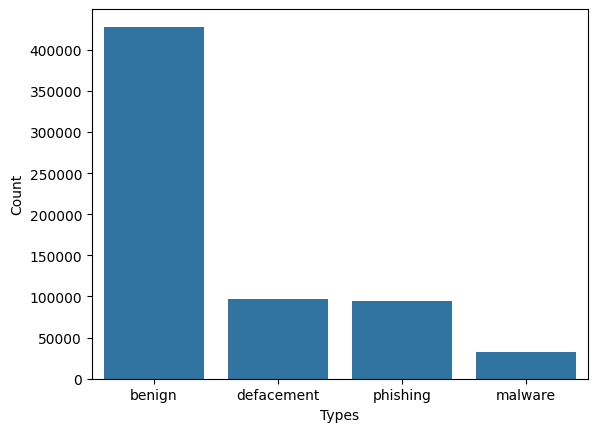

In [9]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

In [10]:
import pandas as pd

# Assuming 'data' is your DataFrame
data['type'] = data['type'].replace({'benign': 'legitimate', 'phishing': 'anonymous', 'defacement': 'anonymous', 'malware': 'anonymous'})

# Display the updated DataFrame
print(data.head())


                                                 url        type
0                                   br-icloud.com.br   anonymous
1                mp3raid.com/music/krizz_kaliko.html  legitimate
2                    bopsecrets.org/rexroth/cr/1.htm  legitimate
3  http://www.garage-pirenne.be/index.php?option=...   anonymous
4  http://adventure-nicaragua.net/index.php?optio...   anonymous


<h4>first have to omit the (www.) from the URL which is in fact a sub domain in itself.</h4>

In [11]:
data.type.value_counts()

,count
type,
legitimate,428103
anonymous,223088


In [12]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,type
0,br-icloud.com.br,anonymous
1,mp3raid.com/music/krizz_kaliko.html,legitimate
2,bopsecrets.org/rexroth/cr/1.htm,legitimate
3,http://garage-pirenne.be/index.php?option=com_...,anonymous
4,http://adventure-nicaragua.net/index.php?optio...,anonymous
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,anonymous
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,anonymous
651188,gamespot.com/xbox360/action/deadspace/,anonymous
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),anonymous


In [13]:
data.head()

,url,type
0,br-icloud.com.br,anonymous
1,mp3raid.com/music/krizz_kaliko.html,legitimate
2,bopsecrets.org/rexroth/cr/1.htm,legitimate
3,http://garage-pirenne.be/index.php?option=com_...,anonymous
4,http://adventure-nicaragua.net/index.php?optio...,anonymous


In [14]:
rem = {"Category": {"legitimate": 0, "anonymous": 1}}
data['Category'] = data['type']
data = data.replace(rem)

/tmp/ipython-input-1491190846.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(rem)


In [15]:
data.head()

,url,type,Category
0,br-icloud.com.br,anonymous,1
1,mp3raid.com/music/krizz_kaliko.html,legitimate,0
2,bopsecrets.org/rexroth/cr/1.htm,legitimate,0
3,http://garage-pirenne.be/index.php?option=com_...,anonymous,1
4,http://adventure-nicaragua.net/index.php?optio...,anonymous,1


<a id="5"></a> <br>
#  Feature Extraction

In [16]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [17]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [18]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [19]:
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,anonymous,1,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,legitimate,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,legitimate,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,anonymous,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,anonymous,1,235,adventure-nicaragua.net


In [20]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [21]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,anonymous,1,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,legitimate,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,legitimate,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,anonymous,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,anonymous,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [22]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [23]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

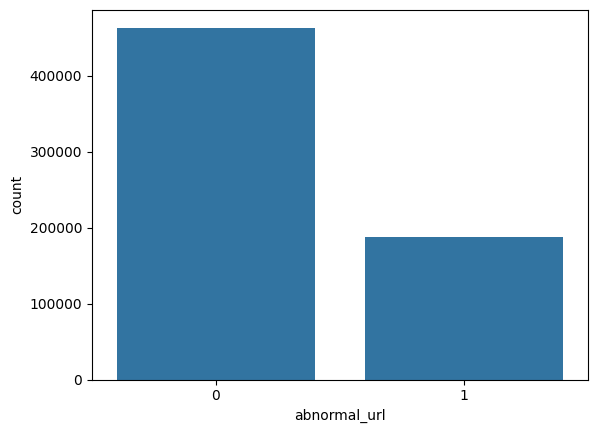

In [24]:
sns.countplot(x='abnormal_url', data=data);

In [25]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [26]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

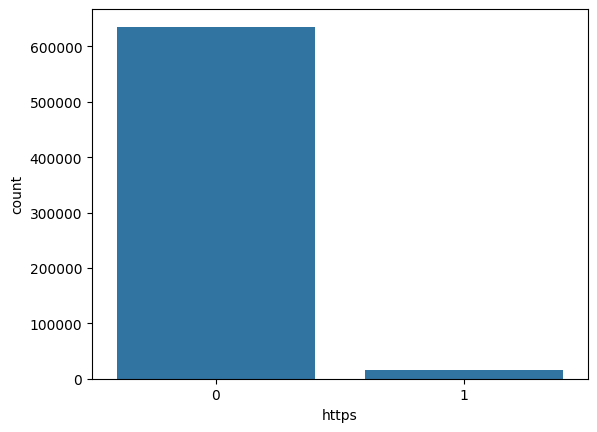

In [27]:
sns.countplot(x='https', data=data);

<h4>Counts the number of digit characters in a URL</h4>

In [28]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [29]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

In [30]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,%,+,$,!,*,",",//,abnormal_url,https,digits
0,br-icloud.com.br,anonymous,1,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,legitimate,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
2,bopsecrets.org/rexroth/cr/1.htm,legitimate,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
3,http://garage-pirenne.be/index.php?option=com_...,anonymous,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,0,0,1,1,0,7
4,http://adventure-nicaragua.net/index.php?optio...,anonymous,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,0,0,1,1,0,22


<h4>Counts the number of letter characters in a URL</h4>

In [31]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [32]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

In [33]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,+,$,!,*,",",//,abnormal_url,https,digits,letters
0,br-icloud.com.br,anonymous,1,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,legitimate,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,legitimate,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,25
3,http://garage-pirenne.be/index.php?option=com_...,anonymous,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,0,1,1,0,7,60
4,http://adventure-nicaragua.net/index.php?optio...,anonymous,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,0,1,1,0,22,199


<h4>Checks to see whether URL contains a shortening service</h4>

In [34]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-610719839.py:2: SyntaxWarning: invalid escape sequence '\.'
  match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
/tmp/ipython

In [35]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))

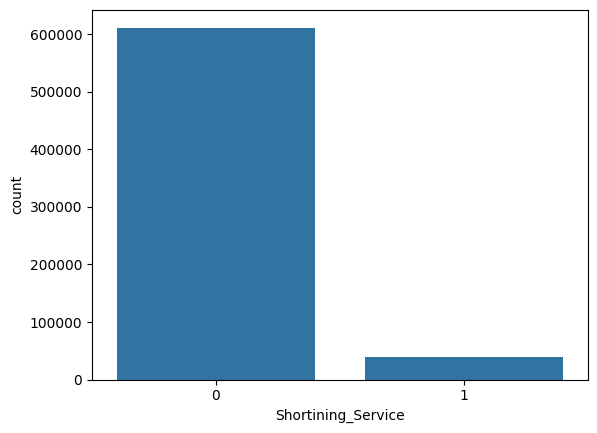

In [36]:
sns.countplot(x='Shortining_Service', data=data);

In [37]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3434034081.py:9: SyntaxWarning: invalid escape sequence '\.'
  '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
/tmp/ipython-input-3434034081.py:10: SyntaxWarning: invalid escape sequence '\d'
  '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6


In [38]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [39]:
data['having_ip_address'].value_counts()

,count
having_ip_address,
0,638703
1,12488


In [40]:
X = data.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data['Category']

<a id="6"></a> <br>
# Train & Test Split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

<a id="7"></a> <br>
# Training models

In [42]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 68.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [43]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

### Decision Tree

In [44]:
# Decision Tree Classifier
dt_model = DecisionTreeClassifier() # creation
dt_model.fit(X_train, y_train)  # Training
dt_pred = dt_model.predict(X_test)    # Prediction
dt_acc = accuracy_score(dt_pred, y_test)
print('Test Accuracy of Decision Tree: ', dt_acc * 100)

Test Accuracy of Decision Tree:  92.51913789264353


In [45]:
# RandomForest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(rf_pred, y_test)
print('Test Accuracy of Random Forest: ', rf_acc * 100)

Test Accuracy of Random Forest:  92.97061556062316


In [46]:
# AdaBoost Classifier
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train, y_train)
adaboost_pred = adaboost_model.predict(X_test)
adaboost_acc = accuracy_score(adaboost_pred, y_test)
print('Test Accuracy of AdaBoost: ', adaboost_acc * 100)

Test Accuracy of AdaBoost:  86.94323512926235


In [47]:
# 35 mins

# KNeighbors Classifier
kneighbors_model = KNeighborsClassifier(n_neighbors=5)
kneighbors_model.fit(X_train, y_train)
kneighbors_pred = kneighbors_model.predict(X_test)
kneighbors_acc = accuracy_score(kneighbors_pred, y_test)
print('Test Accuracy of KNeighbors: ', kneighbors_acc * 100)

Test Accuracy of KNeighbors:  90.87063014918726


In [48]:
# SGD Classifier
sgd_model = SGDClassifier()
sgd_model.fit(X_train, y_train)
sgd_pred = sgd_model.predict(X_test)
sgd_acc = accuracy_score(sgd_pred, y_test)
print('Test Accuracy of SGD: ', sgd_acc * 100)

Test Accuracy of SGD:  85.02829413616504


In [49]:
# Gaussian Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_acc = accuracy_score(nb_pred, y_test)
print('Test Accuracy of Gaussian Naive Bayes: ', nb_acc * 100)

Test Accuracy of Gaussian Naive Bayes:  85.07052419014273


### CNN

In [50]:
# 7 mins

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming X and y are your feature matrix and labels
# You may need to preprocess your data before using it in the model

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert DataFrame to NumPy array and reshape
X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the CNN model
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.8564 - loss: 0.3494 - val_accuracy: 0.8690 - val_loss: 0.3073
Epoch 2/5
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.8734 - loss: 0.2972 - val_accuracy: 0.8791 - val_loss: 0.2870
Epoch 3/5
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.8798 - loss: 0.2890 - val_accuracy: 0.8784 - val_loss: 0.2833
Epoch 4/5
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.8866 - loss: 0.2815 - val_accuracy: 0.8951 - val_loss: 0.2759
Epoch 5/5
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9032 - loss: 0.2591 - val_accuracy: 0.9088 - val_loss: 0.2443


In [51]:

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100}%')


4070/4070 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9090 - loss: 0.2438
Test Accuracy: 90.88214635848999%


### RNN

In [52]:
# 10 mins

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming X and y are your feature matrix and labels
# You may need to preprocess your data before using it in the model

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert DataFrame to NumPy array and reshape
X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the RNN model with LSTM
model = models.Sequential()
model.add(layers.LSTM(32, input_shape=(X_train.shape[1], 1)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))




/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 96s 6ms/step - accuracy: 0.8524 - loss: 0.3464 - val_accuracy: 0.8778 - val_loss: 0.2948
Epoch 2/5
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - accuracy: 0.8753 - loss: 0.2915 - val_accuracy: 0.8830 - val_loss: 0.2788
Epoch 3/5
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - accuracy: 0.8798 - loss: 0.2815 - val_accuracy: 0.8853 - val_loss: 0.2704
Epoch 4/5
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 93s 6ms/step - accuracy: 0.8847 - loss: 0.2731 - val_accuracy: 0.8965 - val_loss: 0.2631
Epoch 5/5
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 92s 6ms/step - accuracy: 0.8899 - loss: 0.2665 - val_accuracy: 0.8886 - val_loss: 0.2643


In [53]:
# Evaluate the model
test_loss, rnn_test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {rnn_test_acc * 100}%')

4070/4070 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8900 - loss: 0.2631
Test Accuracy: 88.85817527770996%


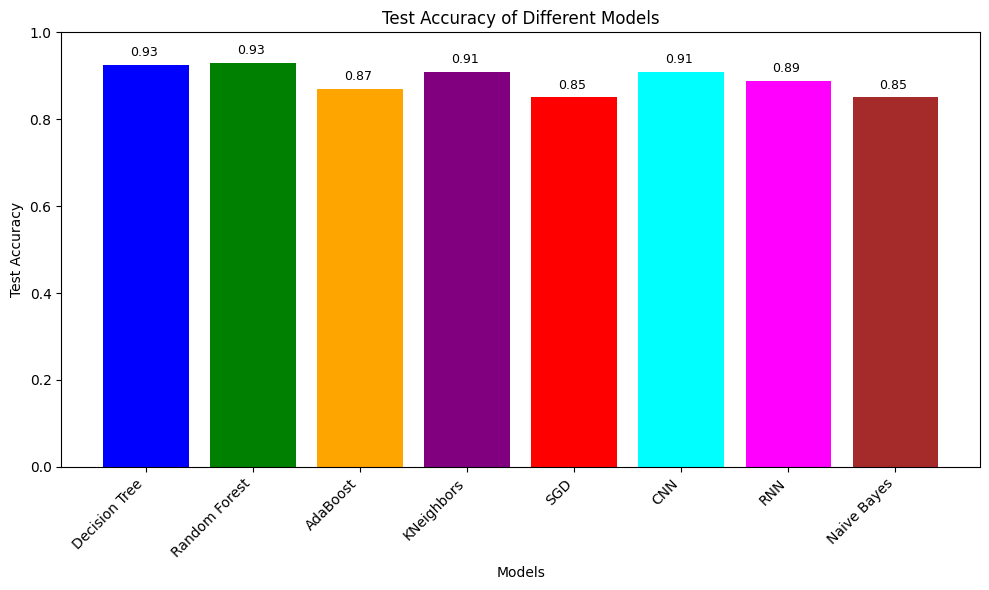

In [54]:
import matplotlib.pyplot as plt

# Assuming you have a list of model names and their corresponding accuracies
model_names = ['Decision Tree', 'Random Forest', 'AdaBoost', 'KNeighbors', 'SGD', 'CNN', 'RNN', 'Naive Bayes']
accuracies = [dt_acc, rf_acc, adaboost_acc, kneighbors_acc, sgd_acc, test_acc, rnn_test_acc, nb_acc]

# Define colors for each model
colors = ['blue', 'green', 'orange', 'purple', 'red', 'cyan', 'magenta', 'brown']

# Plotting the bar graph with different colors
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy of Different Models')
plt.ylim([0, 1])  # Set the y-axis limits to represent accuracy percentage
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Annotate each bar with its corresponding accuracy value
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.02, f'{acc:.2f}', fontsize=9)


# Display the plot
plt.tight_layout()
plt.show()
